# Define segment and predict sales associated

## Importations of packages 

In [48]:
import pandas as pd
from pandas import DataFrame
import numpy as np
import os
import s3fs
import re
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, recall_score
from sklearn.utils import class_weight
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler, MaxAbsScaler, MinMaxScaler
from sklearn.metrics import make_scorer, f1_score, balanced_accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.exceptions import ConvergenceWarning, DataConversionWarning
from sklearn.naive_bayes import GaussianNB
from scipy.optimize import fsolve

import pickle
import warnings

## load databases

In [3]:
# Create filesystem object
S3_ENDPOINT_URL = "https://" + os.environ["AWS_S3_ENDPOINT"]
fs = s3fs.S3FileSystem(client_kwargs={'endpoint_url': S3_ENDPOINT_URL})

In [4]:
def load_train_test():
    BUCKET = "projet-bdc2324-team1/Generalization/sport"
    File_path_train = BUCKET + "/Train_set.csv"
    File_path_test = BUCKET + "/Test_set.csv"
    
    with fs.open( File_path_train, mode="rb") as file_in:
        dataset_train = pd.read_csv(file_in, sep=",")
        # dataset_train['y_has_purchased'] = dataset_train['y_has_purchased'].fillna(0)

    with fs.open(File_path_test, mode="rb") as file_in:
        dataset_test = pd.read_csv(file_in, sep=",")
        # dataset_test['y_has_purchased'] = dataset_test['y_has_purchased'].fillna(0)
    
    return dataset_train, dataset_test

In [5]:
dataset_train, dataset_test = load_train_test()
dataset_train.isna().sum()

/tmp/ipykernel_519/2459610029.py:7: DtypeWarning: Columns (38) have mixed types. Specify dtype option on import or set low_memory=False.
  dataset_train = pd.read_csv(file_in, sep=",")


customer_id                    0
nb_tickets                     0
nb_purchases                   0
total_amount                   0
nb_suppliers                   0
vente_internet_max             0
purchase_date_min              0
purchase_date_max              0
time_between_purchase          0
nb_tickets_internet            0
street_id                      0
structure_id              222825
mcp_contact_id             70874
fidelity                       0
tenant_id                      0
is_partner                     0
deleted_at                224213
gender                         0
is_email_true                  0
opt_in                         0
last_buying_date           66139
max_price                  66139
ticket_sum                     0
average_price              66023
average_purchase_delay     66139
average_price_basket       66139
average_ticket_basket      66139
total_price                  116
purchase_count                 0
first_buying_date          66139
country   

In [6]:
def features_target_split(dataset_train, dataset_test):
    
    features_l = ['nb_tickets', 'nb_purchases', 'total_amount', 'nb_suppliers', 'vente_internet_max', 'purchase_date_min', 'purchase_date_max', 
            'time_between_purchase', 'nb_tickets_internet', 'fidelity',  'is_email_true', 'opt_in', #'is_partner',
            'gender_female', 'gender_male', 'gender_other', 'nb_campaigns', 'nb_campaigns_opened']

    # we suppress fidelity, time between purchase, and gender other (colinearity issue)
    """
    features_l = ['nb_tickets', 'nb_purchases', 'total_amount', 'nb_suppliers', 'vente_internet_max', 
                  'purchase_date_min', 'purchase_date_max', 'nb_tickets_internet',  'is_email_true', 
                  'opt_in', 'gender_female', 'gender_male', 'nb_campaigns', 'nb_campaigns_opened']
    """
    
    X_train = dataset_train[features_l]
    y_train = dataset_train[['y_has_purchased']]

    X_test = dataset_test[features_l]
    y_test = dataset_test[['y_has_purchased']]
    return X_train, X_test, y_train, y_test

In [7]:
X_train, X_test, y_train, y_test = features_target_split(dataset_train, dataset_test)
print("Shape train : ", X_train.shape)
print("Shape test : ", X_test.shape)

Shape train :  (224213, 17)
Shape test :  (96096, 17)


## get results from the logit cross validated model

In [8]:
X_test

nb_tickets  nb_purchases  total_amount  nb_suppliers  \
0             4.0           1.0        100.00           1.0   
1             1.0           1.0         55.00           1.0   
2            17.0           1.0         80.00           1.0   
3             4.0           1.0        120.00           1.0   
4            34.0           2.0        416.00           1.0   
...           ...           ...           ...           ...   
96091         1.0           1.0         67.31           1.0   
96092         1.0           1.0         61.41           1.0   
96093         0.0           0.0          0.00           0.0   
96094         1.0           1.0         79.43           1.0   
96095         0.0           0.0          0.00           0.0   

       vente_internet_max  purchase_date_min  purchase_date_max  \
0                     0.0           5.177187           5.177187   
1                     0.0         426.265613         426.265613   
2                     0.0         436.033437         436.033437   
3                     0.0           5.196412           5.196412   
4                     0.0         478.693148         115.631470   
...                   ...                ...                ...   
96091                 1.0         278.442257         278.442257   
96092                 1.0         189.207373         189.207373   
96093                 0.0         550.000000         550.000000   
96094                 1.0         279.312905         279.312905   
96095                 0.0         550.000000         550.000000   

       time_between_purchase  nb_tickets_internet  fidelity  is_email_true  \
0                   0.000000                  0.0         1           True   
1                   0.000000                  0.0         2           True   
2                   0.000000                  0.0         2           True   
3                   0.000000                  0.0         1           True   
4                 363.061678                  0.0         4           True   
...                      ...                  ...       ...            ...   
96091               0.000000                  1.0         2           True   
96092               0.000000                  1.0         1           True   
96093              -1.000000                  0.0         1           True   
96094               0.000000                  1.0         1           True   
96095              -1.000000                  0.0         2           True   

       opt_in  gender_female  gender_male  gender_other  nb_campaigns  \
0       False              1            0             0           0.0   
1        True              0            1             0           0.0   
2        True              1            0             0           0.0   
3       False              1            0             0           0.0   
4       False              1            0             0           0.0   
...       ...            ...          ...           ...           ...   
96091   False              0            1             0          15.0   
96092   False              0            1             0          12.0   
96093    True              1            0             0          29.0   
96094   False              0            1             0          20.0   
96095   False              0            1             0          31.0   

       nb_campaigns_opened  
0                      0.0  
1                      0.0  
2                      0.0  
3                      0.0  
4                      0.0  
...                    ...  
96091                  5.0  
96092                  9.0  
96093                  3.0  
96094                  4.0  
96095                  4.0  

[96096 rows x 17 columns]

In [9]:
def load_model(type_of_activity, model):
    BUCKET = f"projet-bdc2324-team1/Output_model/{type_of_activity}/{model}/"
    filename = model + '.pkl'
    file_path = BUCKET + filename
    with fs.open(file_path, mode="rb") as f:
        model_bytes = f.read()

    model = pickle.loads(model_bytes)
    return model

In [10]:
logit_cv = load_model("sport", "LogisticRegression_cv")
logit_cv

GridSearchCV(cv=3, error_score='raise',
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('scaler',
                                                                                          StandardScaler())]),
                                                                         ['nb_tickets',
                                                                          'nb_purchases',
                                                                          'total_amount',
                                                                          'nb_suppliers',
                                                                          'vente_internet_max',
                                                                          'purchase_date_min',
                                                                          'purchase_date_max',
                                                                          'time_between_purchase',
                                                                          'nb_tickets_internet',
                                                                          'nb_campaigns',
                                                                          'nb_...
       1.562500e-02, 3.125000e-02, 6.250000e-02, 1.250000e-01,
       2.500000e-01, 5.000000e-01, 1.000000e+00, 2.000000e+00,
       4.000000e+00, 8.000000e+00, 1.600000e+01, 3.200000e+01,
       6.400000e+01]),
                         'LogisticRegression_cv__class_weight': ['balanced',
                                                                 {0.0: 0.5837086520288036,
                                                                  1.0: 3.486549107420539}],
                         'LogisticRegression_cv__penalty': ['l1', 'l2']},
             scoring=make_scorer(recall_score, response_method='predict'))

In [11]:
logit_cv

GridSearchCV(cv=3, error_score='raise',
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('scaler',
                                                                                          StandardScaler())]),
                                                                         ['nb_tickets',
                                                                          'nb_purchases',
                                                                          'total_amount',
                                                                          'nb_suppliers',
                                                                          'vente_internet_max',
                                                                          'purchase_date_min',
                                                                          'purchase_date_max',
                                                                          'time_between_purchase',
                                                                          'nb_tickets_internet',
                                                                          'nb_campaigns',
                                                                          'nb_...
       1.562500e-02, 3.125000e-02, 6.250000e-02, 1.250000e-01,
       2.500000e-01, 5.000000e-01, 1.000000e+00, 2.000000e+00,
       4.000000e+00, 8.000000e+00, 1.600000e+01, 3.200000e+01,
       6.400000e+01]),
                         'LogisticRegression_cv__class_weight': ['balanced',
                                                                 {0.0: 0.5837086520288036,
                                                                  1.0: 3.486549107420539}],
                         'LogisticRegression_cv__penalty': ['l1', 'l2']},
             scoring=make_scorer(recall_score, response_method='predict'))

## Quartile clustering

In [12]:
y_pred = logit_cv.predict(X_test)
y_pred_prob = logit_cv.predict_proba(X_test)[:, 1]

In [13]:
X_test_segment = X_test

X_test_segment["has_purchased"] = y_test
X_test_segment["has_purchased_estim"] = y_pred
X_test_segment["score"] = y_pred_prob
X_test_segment["quartile"] = np.where(X_test['score']<0.25, '1',
                   np.where(X_test['score']<0.5, '2',
                   np.where(X_test['score']<0.75, '3', '4')))
X_test_segment.head(10)

/tmp/ipykernel_519/375041546.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test_segment["has_purchased"] = y_test
/tmp/ipykernel_519/375041546.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test_segment["has_purchased_estim"] = y_pred
/tmp/ipykernel_519/375041546.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/st

nb_tickets  nb_purchases  total_amount  nb_suppliers  vente_internet_max  \
0         4.0           1.0         100.0           1.0                 0.0   
1         1.0           1.0          55.0           1.0                 0.0   
2        17.0           1.0          80.0           1.0                 0.0   
3         4.0           1.0         120.0           1.0                 0.0   
4        34.0           2.0         416.0           1.0                 0.0   
5         2.0           1.0          60.0           1.0                 0.0   
6         5.0           1.0          61.0           1.0                 1.0   
7         4.0           1.0          80.0           1.0                 0.0   
8         1.0           1.0          10.0           1.0                 0.0   
9         3.0           3.0         165.0           1.0                 1.0   

   purchase_date_min  purchase_date_max  time_between_purchase  \
0           5.177187           5.177187               0.000000   
1         426.265613         426.265613               0.000000   
2         436.033437         436.033437               0.000000   
3           5.196412           5.196412               0.000000   
4         478.693148         115.631470             363.061678   
5           5.140069           5.140069               0.000000   
6         105.053773         105.053773               0.000000   
7          63.206030          63.206030               0.000000   
8          44.698090          44.698090               0.000000   
9         266.012106         258.012106               8.000000   

   nb_tickets_internet  fidelity  ...  opt_in  gender_female  gender_male  \
0                  0.0         1  ...   False              1            0   
1                  0.0         2  ...    True              0            1   
2                  0.0         2  ...    True              1            0   
3                  0.0         1  ...   False              1            0   
4                  0.0         4  ...   False              1            0   
5                  0.0         1  ...   False              0            1   
6                  5.0         1  ...   False              0            0   
7                  0.0         1  ...    True              0            1   
8                  0.0         1  ...    True              0            0   
9                  3.0         2  ...   False              0            0   

   gender_other  nb_campaigns  nb_campaigns_opened  has_purchased  \
0             0           0.0                  0.0            0.0   
1             0           0.0                  0.0            1.0   
2             0           0.0                  0.0            0.0   
3             0           0.0                  0.0            0.0   
4             0           0.0                  0.0            1.0   
5             0           0.0                  0.0            0.0   
6             1           0.0                  0.0            0.0   
7             0           0.0                  0.0            0.0   
8             1           0.0                  0.0            0.0   
9             1           0.0                  0.0            0.0   

   has_purchased_estim     score  quartile  
0                  1.0  0.657671         3  
1                  0.0  0.266538         2  
2                  0.0  0.214668         1  
3                  1.0  0.657770         3  
4                  1.0  0.894173         4  
5                  1.0  0.717482         3  
6                  1.0  0.541855         3  
7                  0.0  0.461164         2  
8                  0.0  0.310828         2  
9                  0.0  0.452877         2  

[10 rows x 21 columns]

## definition of functions to compute the bias of scores and adjust it 

Le biais est calculé de la façon suivante. 
En notant $\hat{p(x_i)}$ le score calculé (estimé par la modélisation) et $p(x_i)$ le vrai score (sans biais), et $\beta$ le logarithme du biais, on a : \
$\ln{\frac{\hat{p(x_i)}}{1-\hat{p(x_i)}}} = \beta + \ln{\frac{p(x_i)}{1-p(x_i)}}$ \
$ \frac{\hat{p(x_i)}}{1-\hat{p(x_i)}} = \exp(\beta) . \frac{p(x_i)}{1-p(x_i)} $ , soit : \
$p(x_i) = {\frac{\frac{\hat{p(x_i)}}{1-\hat{p(x_i)}}}{B+\frac{\hat{p(x_i)}}{1-\hat{p(x_i)}}}}$ \
Ce qu'on appelle biais et qu'on estime dans le code par la suite est : $B=\exp(\beta) $. Les probabilités ne sont donc pas biaisées si $B=1$. Il y a surestimation si $B>1$. 

On cherche le B qui permette d'ajuster les probabilités de telle sorte que la somme des scores soit égale à la somme des y_has_purchased. Cela revient à résoudre : 

\begin{equation}
\sum_{i}{\frac{\frac{\hat{p(x_i)}}{1-\hat{p(x_i)}}}{B+\frac{\hat{p(x_i)}}{1-\hat{p(x_i)}}}} = \sum_{i}{Y_i}
\end{equation}

C'est ce que fait la fonction find_bias. 

Note sur les notations : \
$\hat{p(x_i)}$ correspond à ce qu'on appelle le score et $p(x_i)$ à ce qu'on appellera le score adjusted

In [14]:
# compute adjusted score from odd ratios (cf formula above)
def adjusted_score(odd_ratio, bias) :
    adjusted_score = odd_ratio/(bias+odd_ratio)
    return adjusted_score

In [15]:
# when the score is 1 we cannot compute the odd ratio, so we adjust scores equal to 1
# we set the second best score instead

def adjust_score_1(score) :
    second_best_score = np.array([element for element in score if element !=1]).max()
    new_score = np.array([element if element!=1 else second_best_score for element in score])    
    return new_score

In [16]:
def odd_ratio(score) :
    return score / (1 - score)

In [17]:
# definition of a function that automatically detects the bias

def find_bias(odd_ratios, y_objective, initial_guess=6) :
    """
    results = minimize(lambda bias : (sum([adjusted_score(element, bias) for element in list(odd_ratios)]) - y_objective)**2 ,
    initial_guess , method = "BFGS")

    estimated_bias = results.x[0]
    """

    # faster method
    bias_estimated = fsolve(lambda bias : sum([adjusted_score(element, bias) for element in list(odd_ratios)]) - y_objective, x0=6)
 
    return bias_estimated[0]

In [18]:
# computation with the function defined

bias_test_set = find_bias(odd_ratios = odd_ratio(adjust_score_1(X_test_segment["score"])), 
                           y_objective = y_test["y_has_purchased"].sum(),
                           initial_guess=6)
bias_test_set

6.172331113516847

In [19]:
# comparison with bias of the train set
X_train_score = logit_cv.predict_proba(X_train)[:, 1]

bias_train_set = find_bias(odd_ratios = odd_ratio(adjust_score_1(X_train_score)), 
                           y_objective = y_train["y_has_purchased"].sum(),
                           initial_guess=6)
bias_train_set

6.070461139075353

In [20]:
print("betâ test - betâ train = ",np.log(bias_test_set/bias_train_set))

betâ test - betâ train =  0.016642008368292337


In [21]:
# impact of considering a bias computed on train set instead of test set - totally neglectable

score_adjusted_test = adjusted_score(odd_ratio(adjust_score_1(X_test_segment["score"])), bias = bias_test_set)
score_adjusted_train = adjusted_score(odd_ratio(adjust_score_1(X_test_segment["score"])), bias = bias_train_set)

print("mean absolute erreur",abs(score_adjusted_test-score_adjusted_train).mean())

mean absolute erreur 0.001409799678121875


In [22]:
# adjust scores accordingly 

# X_test_segment["score_adjusted"] = adjusted_score(odd_ratio(adjust_score_1(X_test_segment["score"])), bias = bias_test_set)

# actually, we are not supposed to have X_test, so the biais is estimated on X_train
# X_test_segment["score_adjusted"] = adjusted_score(odd_ratio(adjust_score_1(X_test_segment["score"])), bias = bias_train_set)
X_test_segment["score_adjusted"] = score_adjusted_train

/tmp/ipykernel_519/1825363704.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test_segment["score_adjusted"] = score_adjusted_train


In [23]:
# check 

MSE_score = ((X_test_segment["score"]-X_test_segment["has_purchased"])**2).mean()
MSE_ajusted_score = ((X_test_segment["score_adjusted"]-X_test_segment["has_purchased"])**2).mean()
print(f"MSE for score : {MSE_score}")
print(f"MSE for ajusted score : {MSE_ajusted_score}")

print("sum of y_has_purchased :",y_test["y_has_purchased"].sum())
print("sum of adjusted scores :", X_test_segment["score_adjusted"].sum())

MSE for score : 0.15494387585189107
MSE for ajusted score : 0.08851697393139933
sum of y_has_purchased : 13690.0
sum of adjusted scores : 13825.476109871417


In [25]:
# mean absolute error - divided by 2 with out method

MAE_score = abs(X_test_segment["score"]-X_test_segment["has_purchased"]).mean()
MAE_ajusted_score = abs(X_test_segment["score_adjusted"]-X_test_segment["has_purchased"]).mean()
print(f"MAE for score : {MAE_score}")
print(f"MAE for adjusted score : {MAE_ajusted_score}")

MAE for score : 0.32116357895490416
MAE for adjusted score : 0.17359227315595824


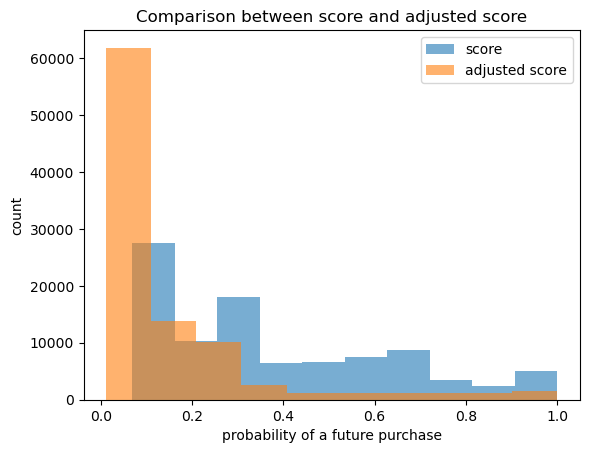

In [26]:
# visualization

# histogramme des probas et des probas ajustées

def plot_hist_scores(df, score, score_adjusted) :

    plt.figure()
    plt.hist(df[score], label = "score", alpha=0.6)
    plt.hist(df[score_adjusted], label="adjusted score", alpha=0.6)
    plt.legend()
    plt.xlabel("probability of a future purchase")
    plt.ylabel("count")
    plt.title("Comparison between score and adjusted score")
    plt.show()

plot_hist_scores(X_test_segment, score = "score", score_adjusted = "score_adjusted")

## Compute number of tickets and CA by segment with the recalibrated score

In [27]:
X_test_segment.head()

nb_tickets  nb_purchases  total_amount  nb_suppliers  vente_internet_max  \
0         4.0           1.0         100.0           1.0                 0.0   
1         1.0           1.0          55.0           1.0                 0.0   
2        17.0           1.0          80.0           1.0                 0.0   
3         4.0           1.0         120.0           1.0                 0.0   
4        34.0           2.0         416.0           1.0                 0.0   

   purchase_date_min  purchase_date_max  time_between_purchase  \
0           5.177187           5.177187               0.000000   
1         426.265613         426.265613               0.000000   
2         436.033437         436.033437               0.000000   
3           5.196412           5.196412               0.000000   
4         478.693148         115.631470             363.061678   

   nb_tickets_internet  fidelity  ...  gender_female  gender_male  \
0                  0.0         1  ...              1            0   
1                  0.0         2  ...              0            1   
2                  0.0         2  ...              1            0   
3                  0.0         1  ...              1            0   
4                  0.0         4  ...              1            0   

   gender_other  nb_campaigns  nb_campaigns_opened  has_purchased  \
0             0           0.0                  0.0            0.0   
1             0           0.0                  0.0            1.0   
2             0           0.0                  0.0            0.0   
3             0           0.0                  0.0            0.0   
4             0           0.0                  0.0            1.0   

   has_purchased_estim     score  quartile  score_adjusted  
0                  1.0  0.657671         3        0.240397  
1                  0.0  0.266538         2        0.056482  
2                  0.0  0.214668         1        0.043089  
3                  1.0  0.657770         3        0.240478  
4                  1.0  0.894173         4        0.581920  

[5 rows x 22 columns]

In [28]:
X_test_segment.groupby("quartile")[["score","score_adjusted", "has_purchased"]].mean()

score  score_adjusted  has_purchased
quartile                                         
1         0.132457        0.025105       0.015691
2         0.338914        0.079990       0.098486
3         0.630647        0.225757       0.214729
4         0.905216        0.661997       0.650133

In [57]:
def project_tickets_CA (df, nb_tickets, total_amount, score_adjusted, duration_ref, duration_projection) :
    
    duration_ratio = duration_ref/duration_projection

    df_output = df

    df_output["nb_tickets_projected"] = df_output[nb_tickets] / duration_ratio
    df_output["total_amount_projected"] = df_output[total_amount] / duration_ratio
    
    df_output["nb_tickets_expected"] = df_output[score_adjusted] * df_output["nb_tickets_projected"]
    df_output["total_amount_expected"] = df_output[score_adjusted] * df_output["total_amount_projected"]

    return df_output


In [124]:
X_test_segment

nb_tickets  nb_purchases  total_amount  nb_suppliers  \
0             4.0           1.0        100.00           1.0   
1             1.0           1.0         55.00           1.0   
2            17.0           1.0         80.00           1.0   
3             4.0           1.0        120.00           1.0   
4            34.0           2.0        416.00           1.0   
...           ...           ...           ...           ...   
96091         1.0           1.0         67.31           1.0   
96092         1.0           1.0         61.41           1.0   
96093         0.0           0.0          0.00           0.0   
96094         1.0           1.0         79.43           1.0   
96095         0.0           0.0          0.00           0.0   

       vente_internet_max  purchase_date_min  purchase_date_max  \
0                     0.0           5.177187           5.177187   
1                     0.0         426.265613         426.265613   
2                     0.0         436.033437         436.033437   
3                     0.0           5.196412           5.196412   
4                     0.0         478.693148         115.631470   
...                   ...                ...                ...   
96091                 1.0         278.442257         278.442257   
96092                 1.0         189.207373         189.207373   
96093                 0.0         550.000000         550.000000   
96094                 1.0         279.312905         279.312905   
96095                 0.0         550.000000         550.000000   

       time_between_purchase  nb_tickets_internet  fidelity  ...  \
0                   0.000000                  0.0         1  ...   
1                   0.000000                  0.0         2  ...   
2                   0.000000                  0.0         2  ...   
3                   0.000000                  0.0         1  ...   
4                 363.061678                  0.0         4  ...   
...                      ...                  ...       ...  ...   
96091               0.000000                  1.0         2  ...   
96092               0.000000                  1.0         1  ...   
96093              -1.000000                  0.0         1  ...   
96094               0.000000                  1.0         1  ...   
96095              -1.000000                  0.0         2  ...   

       gender_female  gender_male  gender_other  nb_campaigns  \
0                  1            0             0           0.0   
1                  0            1             0           0.0   
2                  1            0             0           0.0   
3                  1            0             0           0.0   
4                  1            0             0           0.0   
...              ...          ...           ...           ...   
96091              0            1             0          15.0   
96092              0            1             0          12.0   
96093              1            0             0          29.0   
96094              0            1             0          20.0   
96095              0            1             0          31.0   

       nb_campaigns_opened  has_purchased  has_purchased_estim     score  \
0                      0.0            0.0                  1.0  0.657671   
1                      0.0            1.0                  0.0  0.266538   
2                      0.0            0.0                  0.0  0.214668   
3                      0.0            0.0                  1.0  0.657770   
4                      0.0            1.0                  1.0  0.894173   
...                    ...            ...                  ...       ...   
96091                  5.0            1.0                  1.0  0.623551   
96092                  9.0            0.0                  1.0  0.682521   
96093                  3.0            0.0                  0.0  0.117192   
96094                  4.0            0.0                  1.0  0.625185   
96095      

In [56]:
X_test_segment = project_tickets_CA (X_test_segment, "nb_tickets", "total_amount", "score_adjusted", duration_ref=1.5, duration_projection=1)
X_test_segment

/tmp/ipykernel_519/3509011500.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_output["nb_tickets_projected"] = df_output[nb_tickets] / duration_ratio
/tmp/ipykernel_519/3509011500.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_output["total_amount_projected"] = df_output[total_amount] / duration_ratio
/tmp/ipykernel_519/3509011500.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the 

nb_tickets  nb_purchases  total_amount  nb_suppliers  \
0             4.0           1.0        100.00           1.0   
1             1.0           1.0         55.00           1.0   
2            17.0           1.0         80.00           1.0   
3             4.0           1.0        120.00           1.0   
4            34.0           2.0        416.00           1.0   
...           ...           ...           ...           ...   
96091         1.0           1.0         67.31           1.0   
96092         1.0           1.0         61.41           1.0   
96093         0.0           0.0          0.00           0.0   
96094         1.0           1.0         79.43           1.0   
96095         0.0           0.0          0.00           0.0   

       vente_internet_max  purchase_date_min  purchase_date_max  \
0                     0.0           5.177187           5.177187   
1                     0.0         426.265613         426.265613   
2                     0.0         436.033437         436.033437   
3                     0.0           5.196412           5.196412   
4                     0.0         478.693148         115.631470   
...                   ...                ...                ...   
96091                 1.0         278.442257         278.442257   
96092                 1.0         189.207373         189.207373   
96093                 0.0         550.000000         550.000000   
96094                 1.0         279.312905         279.312905   
96095                 0.0         550.000000         550.000000   

       time_between_purchase  nb_tickets_internet  fidelity  ...  \
0                   0.000000                  0.0         1  ...   
1                   0.000000                  0.0         2  ...   
2                   0.000000                  0.0         2  ...   
3                   0.000000                  0.0         1  ...   
4                 363.061678                  0.0         4  ...   
...                      ...                  ...       ...  ...   
96091               0.000000                  1.0         2  ...   
96092               0.000000                  1.0         1  ...   
96093              -1.000000                  0.0         1  ...   
96094               0.000000                  1.0         1  ...   
96095              -1.000000                  0.0         2  ...   

       nb_campaigns_opened  has_purchased  has_purchased_estim     score  \
0                      0.0            0.0                  1.0  0.657671   
1                      0.0            1.0                  0.0  0.266538   
2                      0.0            0.0                  0.0  0.214668   
3                      0.0            0.0                  1.0  0.657770   
4                      0.0            1.0                  1.0  0.894173   
...                    ...            ...                  ...       ...   
96091                  5.0            1.0                  1.0  0.623551   
96092                  9.0            0.0                  1.0  0.682521   
96093                  3.0            0.0                  0.0  0.117192   
96094                  4.0            0.0                  1.0  0.625185   
96095                  4.0            0.0                  0.0  0.319585   

       quartile  score_adjusted  nb_tickets_projected  total_amount_projected  \
0             3        0.240397              2.666667               66.666667   
1             2        0.056482              0.666667               36.666667   
2             1        0.043089             11.333333               53.333333   
3             3        0.240478              2.666667               80.000000   
4             4        0.581920             22.666667              277.333333   
...         ...             ...                   ...                     ...   
96091         3        0.214369              0.666667               44.873333   
96092         3        0.261526              0.666667              

In [169]:
# compute nb tickets estimated and total amount expected
X_test_expected_CA = X_test_segment.groupby("quartile")[["nb_tickets_expected", "total_amount_expected"]].sum().reset_index()

# number of customers by segment
X_test_expected_CA.insert(1, "size", X_test_segment.groupby("quartile").size().values)

# size in percent of all customers
X_test_expected_CA.insert(2, "size_perct", 100 * X_test_expected_CA["size"]/X_test_expected_CA["size"].sum())

# compute share of CA recovered
duration_ref=1.5
duration_projection=1
duration_ratio=duration_ref/duration_projection

X_test_expected_CA["perct_revenue_recovered"] = 100 * duration_ratio * X_test_expected_CA["total_amount_expected"] / \
X_test_segment.groupby("quartile")["total_amount"].sum().values

X_test_expected_CA

quartile   size  size_perct  nb_tickets_expected  total_amount_expected  \
0        1  37410   38.929820            84.764915           1.867190e+03   
1        2  29517   30.716159          2899.288091           7.446102e+04   
2        3  20137   20.955087         10876.786661           3.442867e+05   
3        4   9032    9.398934        215194.829104           9.899418e+06   

   perct_revenue_recovered  
0                 4.384354  
1                 9.854069  
2                22.842135  
3                90.107285

In [31]:
# generalization with a function

def summary_expected_CA(df, segment, nb_tickets_expected, total_amount_expected, total_amount) :
    
    # compute nb tickets estimated and total amount expected
    df_expected_CA = df.groupby(segment)[[nb_tickets_expected, total_amount_expected]].sum().reset_index()
    
    # number of customers by segment
    df_expected_CA.insert(1, "size", df.groupby(segment).size().values)
    
    # size in percent of all customers
    df_expected_CA.insert(2, "size_perct", 100 * df_expected_CA["size"]/df_expected_CA["size"].sum())
    
    # compute share of CA recovered
    duration_ref=1.5
    duration_projection=1
    duration_ratio=duration_ref/duration_projection
    
    df_expected_CA["perct_revenue_recovered"] = 100 * duration_ratio * df_expected_CA[total_amount_expected] / \
    df.groupby(segment)[total_amount].sum().values
    
    return df_expected_CA

In [38]:
round(summary_expected_CA(df=X_test_segment, segment="quartile", nb_tickets_expected="nb_tickets_expected", 
                    total_amount_expected="total_amount_expected", total_amount="total_amount"),2)

## Just to try, same computation with score instead of score adjusted

seems overestimated : if only 14% of customers come back, how can we recover 22% of the revenue from the segment that is least likely to buy ?? ...

In [201]:
X_test_segment_bis = project_tickets_CA (X_test_segment, "nb_tickets", "total_amount", "score", duration_ref=1.5, duration_projection=1)

# compute nb tickets estimated and total amount expected
X_test_expected_CA_bis = X_test_segment_bis.groupby("quartile")[["nb_tickets_expected", "total_amount_expected"]].sum().reset_index()

# number of customers by segment
X_test_expected_CA_bis.insert(1, "size", X_test_segment_bis.groupby("quartile").size().values)

# size in percent of all customers
X_test_expected_CA_bis.insert(2, "size_perct", 100 * X_test_expected_CA_bis["size"]/X_test_expected_CA_bis["size"].sum())

# compute share of CA recovered
duration_ref=1.5
duration_projection=1
duration_ratio=duration_ref/duration_projection

X_test_expected_CA_bis["perct_revenue_recovered"] = 100 * duration_ratio * X_test_expected_CA_bis["total_amount_expected"] / \
X_test_segment_bis.groupby("quartile")["total_amount"].sum().values

X_test_expected_CA_bis

/tmp/ipykernel_620/3599949626.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_output["nb_tickets_projected"] = df_output[nb_tickets] / duration_ratio
/tmp/ipykernel_620/3599949626.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_output["total_amount_projected"] = df_output[total_amount] / duration_ratio
/tmp/ipykernel_620/3599949626.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the 

quartile   size  size_perct  nb_tickets_expected  total_amount_expected  \
0        1  37410   38.929820           419.757918           9.245081e+03   
1        2  29517   30.716159         11549.060736           2.965220e+05   
2        3  20137   20.955087         29997.854731           9.547519e+05   
3        4   9032    9.398934        244655.821195           1.073601e+07   

   perct_revenue_recovered  
0                21.708404  
1                39.241320  
2                63.344224  
3                97.722201

In [203]:
print("overall share of revenue recovered : ", round(100 * duration_ratio * X_test_expected_CA_bis["total_amount_expected"].sum() / \
X_test_segment_bis["total_amount"].sum(),2), "%")

overall share of revenue recovered :  90.26 %


## Last pieces of analysis

In [161]:
# global revenue recovered
global_revenue_recovered = round(100 * duration_ratio * X_test_expected_CA["total_amount_expected"].sum() / \
X_test_segment["total_amount"].sum(),2)
print(f"overall share of revenue recovered : {global_revenue_recovered}%")

overall share of revenue recovered : 77.64%


In [163]:
100 * X_test_expected_CA["total_amount_expected"]/X_test_expected_CA["total_amount_expected"].sum()

0     0.018093
1     0.721519
2     3.336101
3    95.924287
Name: total_amount_expected, dtype: float64

In [166]:
# le segment 4 représente 83% du CA actuel et 96% du CA lié aux anciens clients pour l'année prochaine
100 * X_test_segment.groupby("quartile")["total_amount"].sum()/X_test_segment["total_amount"].sum()

quartile
1     0.320407
2     5.685020
3    11.339715
4    82.654858
Name: total_amount, dtype: float64

In [ ]:
# graphique - loi de Pareto sur le CA généré


In [177]:
X_test_segment["total_amount"].describe() # total amount négatif ???


count     96096.000000
mean        207.475735
std        4720.046248
min      -48831.800000
25%           0.000000
50%           0.000000
75%          60.000000
max      624890.000000
Name: total_amount, dtype: float64

In [184]:
np.cumsum(X_test_segment["total_amount"].sort_values()).reset_index()["total_amount"]

0       -4.883180e+04
1       -6.483180e+04
2       -7.683860e+04
3       -8.683860e+04
4       -9.683860e+04
             ...     
96091    1.802247e+07
96092    1.839238e+07
96093    1.877219e+07
96094    1.931270e+07
96095    1.993759e+07
Name: total_amount, Length: 96096, dtype: float64

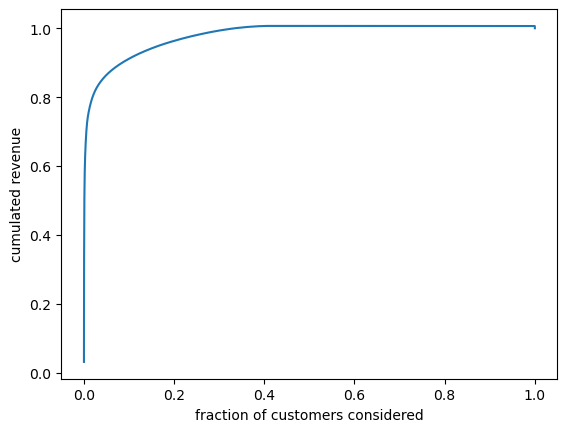

In [200]:
# graphic for cumulated revenue

plt.figure()
plt.plot(X_test_segment.index/X_test_segment.index.max(), 
         np.cumsum(X_test_segment["total_amount"].sort_values(ascending=False)).values/ \
        np.sum(X_test_segment["total_amount"]))
plt.xlabel("fraction of customers considered")
plt.ylabel("cumulated revenue")
plt.show()

In [198]:
X_test_segment.index.max()

96095